In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import sys, yaml, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ' '*7+'Internal Simulation'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
category = 'low'
card_name = 'v13'+category+'_Asimov'

In [4]:
histosLoc = '../data/_root/histos4combine/{}_{}_q2bin{}.root'
fileH = {}
for var in ['M2_miss', 'Est_mu']:
    for iq2 in [2,3]:
        n = var+str(iq2)
        fileH[n] = rt.TFile.Open(histosLoc.format(card_name, var, iq2), 'READ')

In [5]:
outdir = '../Combine/results/'+card_name + '/fig/shapeUncertainties'
if os.path.isdir(outdir):
    os.system('rm -rf '+outdir)
os.system('mkdir -p '+outdir)

0

In [6]:
q2binning = [-2, 2.5, 6, 9.4, 12]
CMS_lumi.integrated_lumi = {'low':6.4, 'mid':20.7, 'high':26.4}[category] #fb^-1
inj_RDst = 0.295

In [7]:
keysList = []
for k in fileH.values()[0].GetListOfKeys():
    keysList.append(k.GetTitle())
keysList = np.sort(keysList)
procList = np.sort([k for k in keysList if not '__' in k and not 'Data' in k])

In [8]:
hCentral = {}

for kk ,f in fileH.iteritems():
    hCentral[kk] = None
    for k in procList:
        hAux = f.Get(k)
        if hCentral[kk] is None:
            hCentral[kk] = hAux.Clone('Cent.')
        else:
            c = inj_RDst if k == 'tau' else 1
            hCentral[kk].Add(hAux, c)
            
    hCentral[kk].SetTitle('Central')
    hCentral[kk].GetYaxis().SetTitle('Events')
    if 'M2_miss' in kk:
        title = 'M^{2}_{miss} [GeV^{2}]'
    elif 'Est_mu' in kk:
        title = 'E*_{#mu} [GeV]'
    hCentral[kk].GetXaxis().SetTitle(title)
    hCentral[kk].GetYaxis().SetRangeUser(0, 1.3*hCentral[kk].GetMaximum())

In [9]:
def getVarHistos(tag):
    hOut = {}

    for kk ,f in fileH.iteritems():
        hOut[kk] = None
        for p in procList:
            k = p+'__'+tag
            if not k in keysList:
                k = p

            hAux = f.Get(k)
            if hOut[kk] is None:
                hOut[kk] = hAux.Clone(tag)
            else:
                c = inj_RDst if 'tau' in k else 1
                hOut[kk].Add(hAux, c)
        hOut[kk].SetTitle(tag)
    return hOut

In [10]:
variationsList = list(set([k[k.find('__')+2:] for k in keysList if '__' in k]))
variationsList = np.sort([k[:-2] for k in variationsList if k[-2:] == 'Up'])

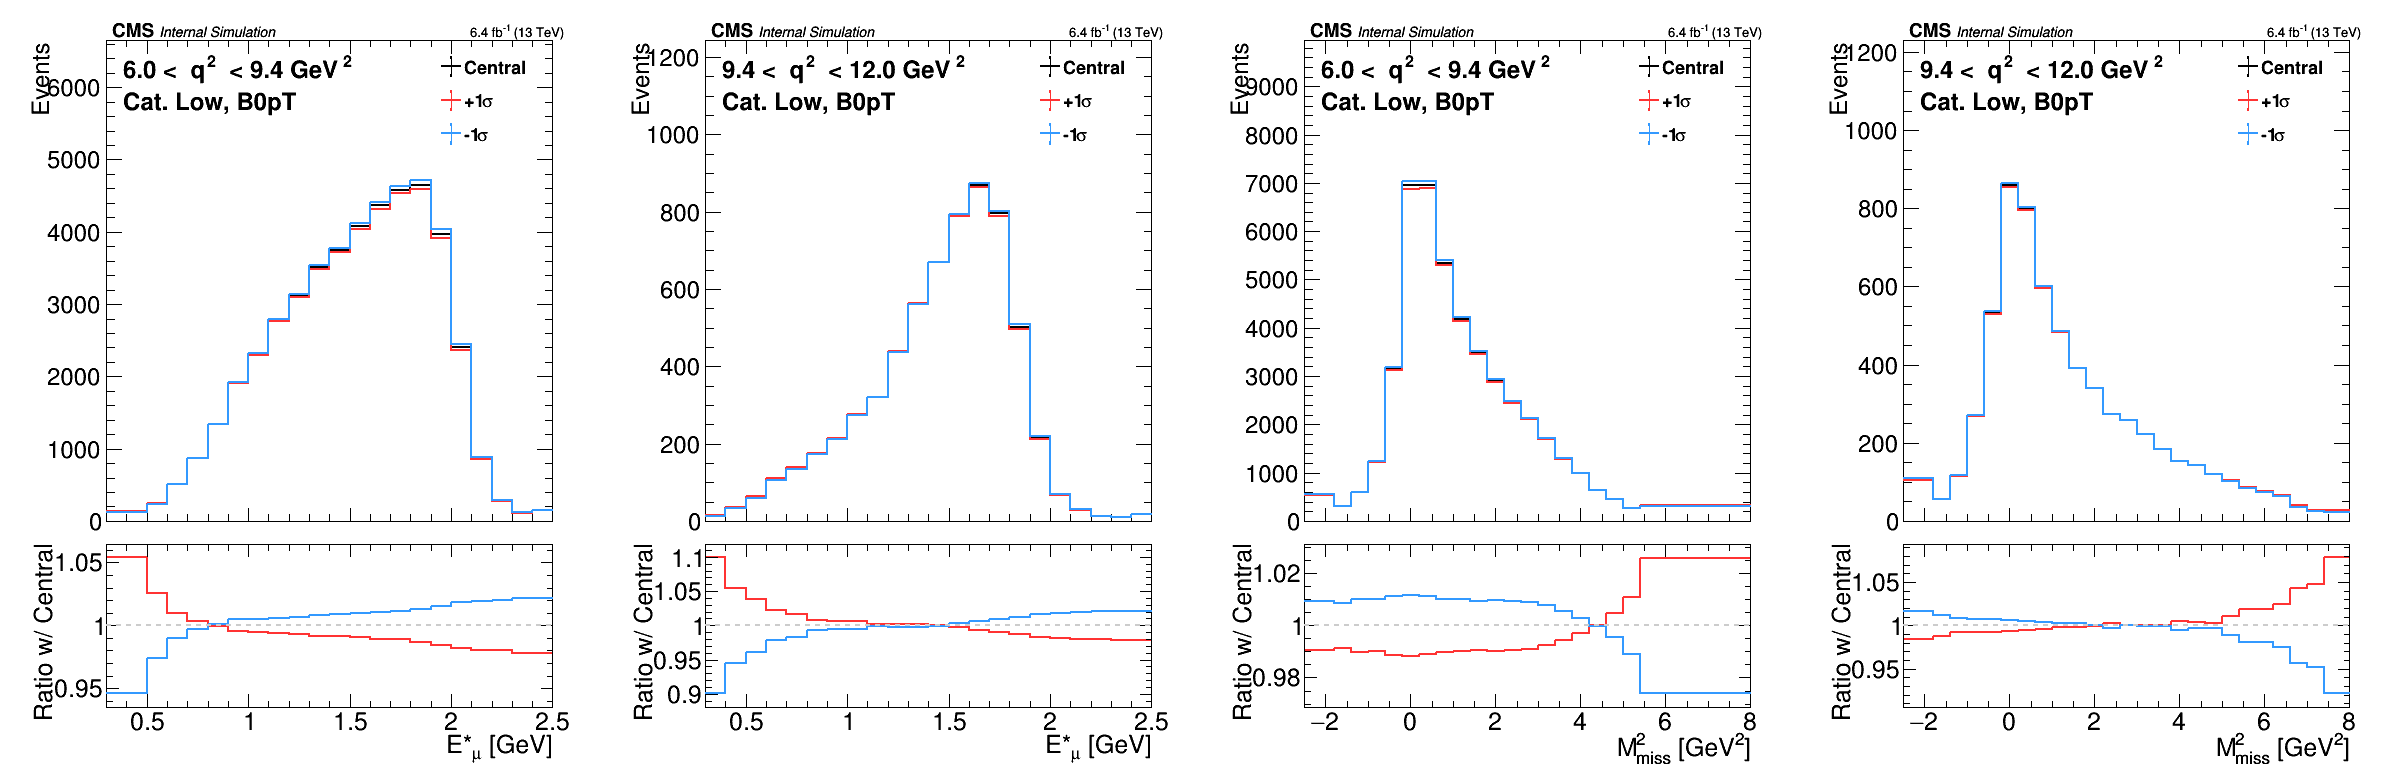

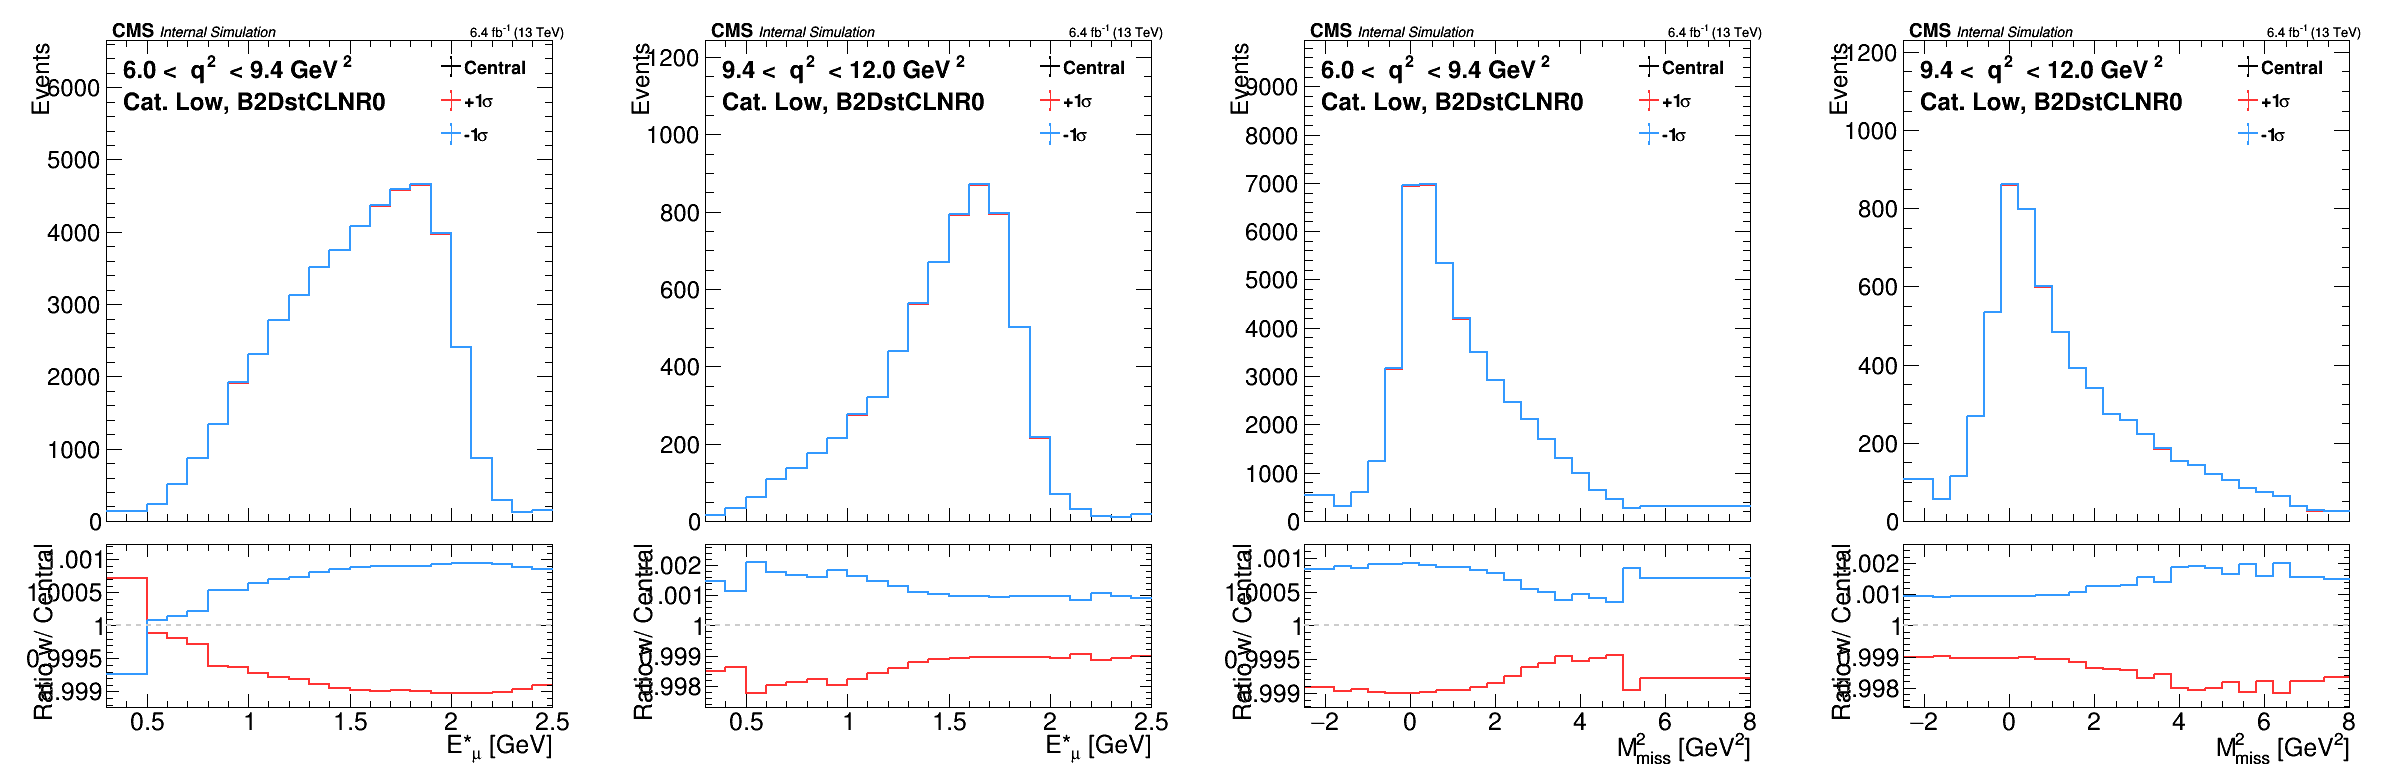

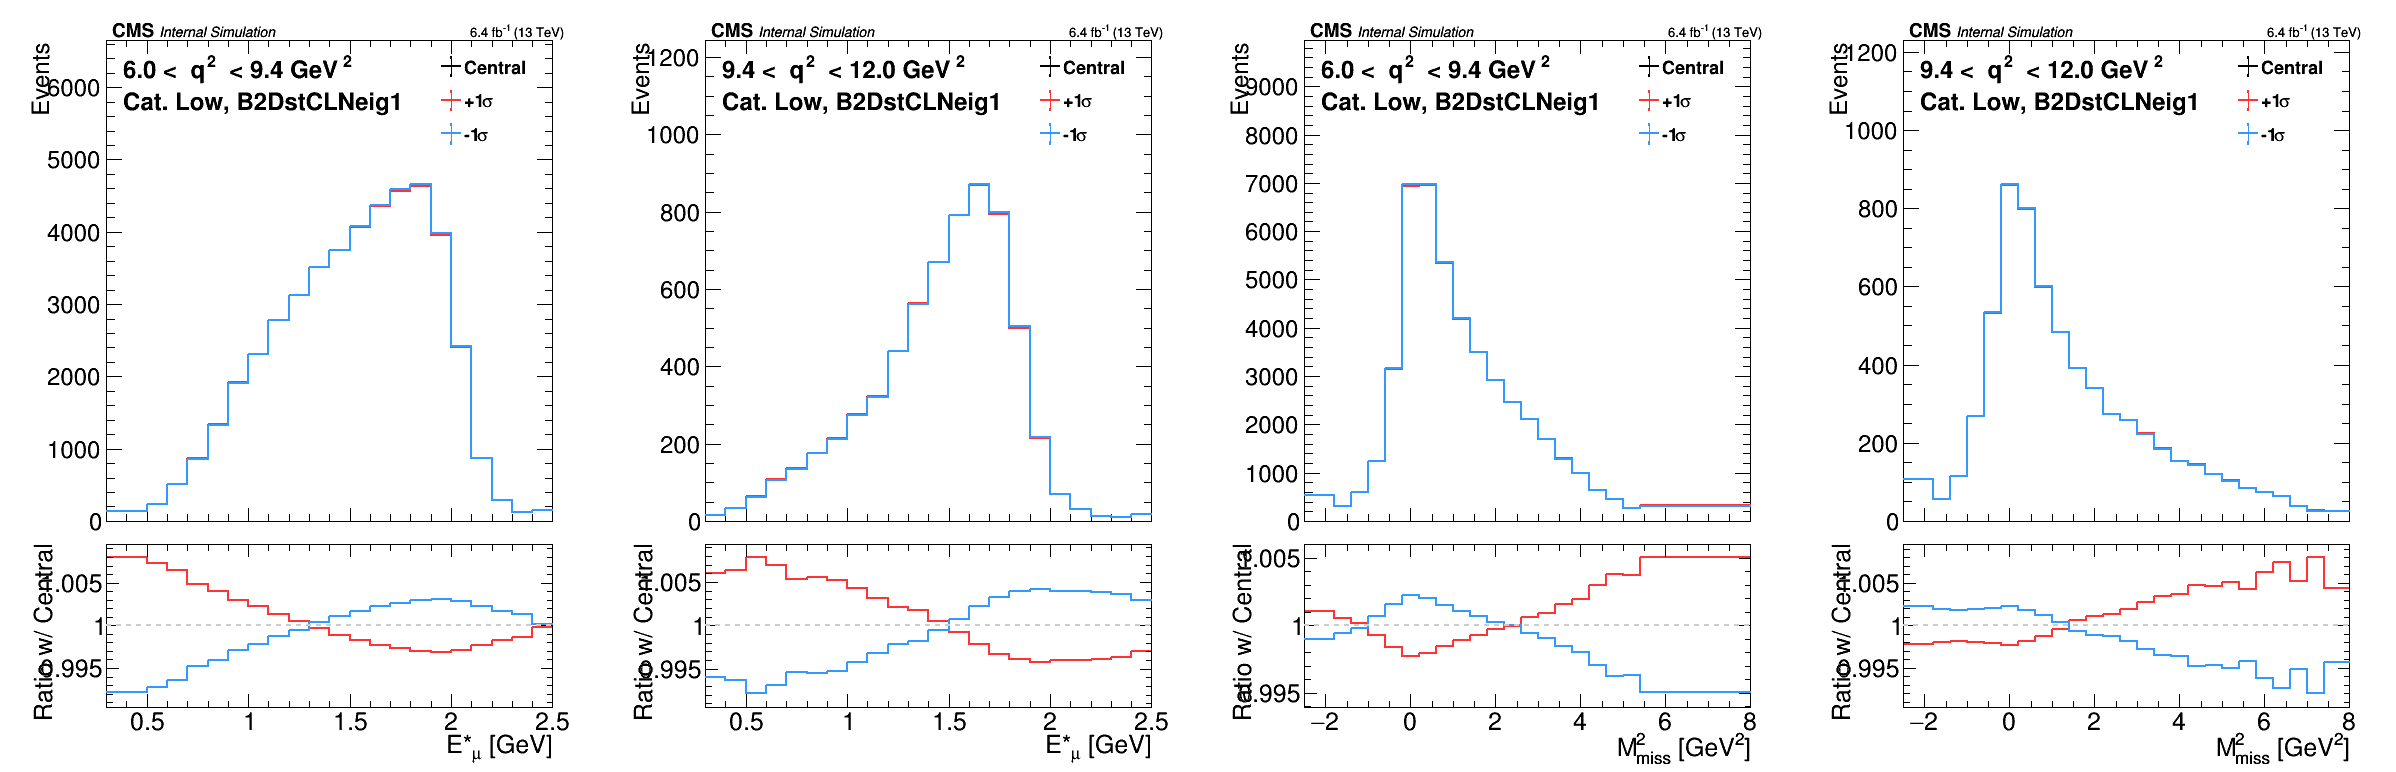

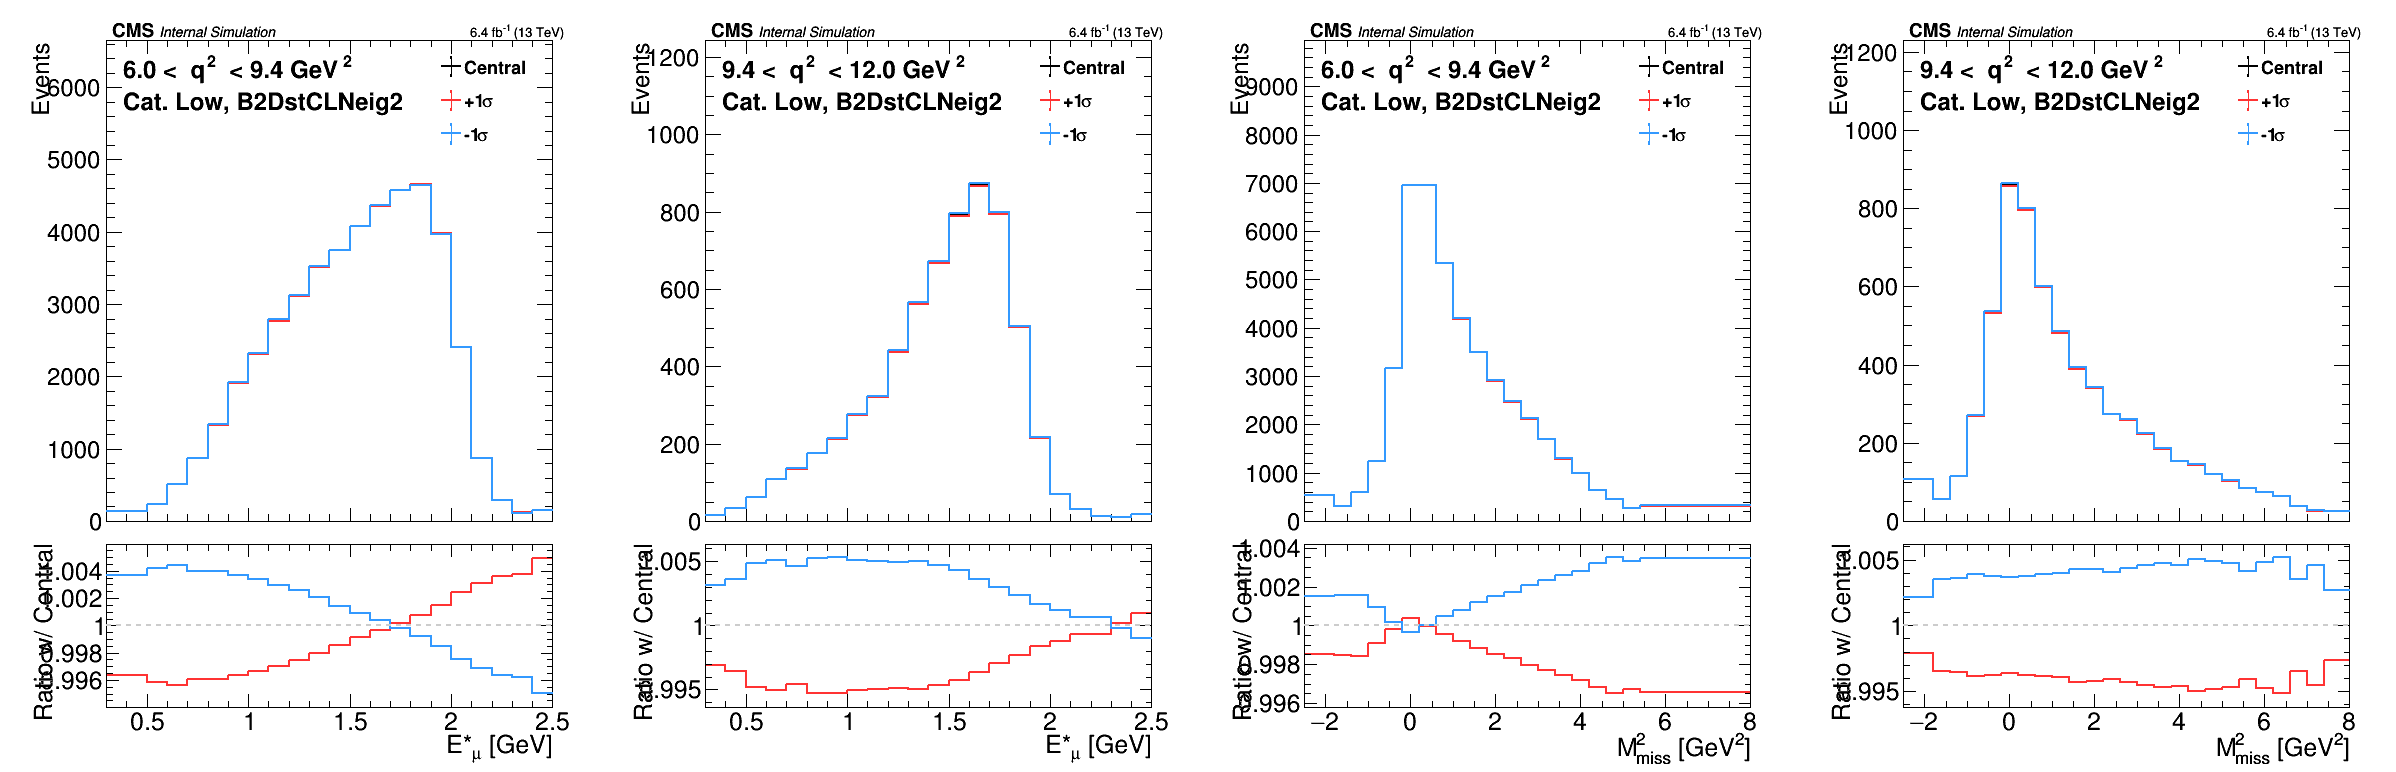

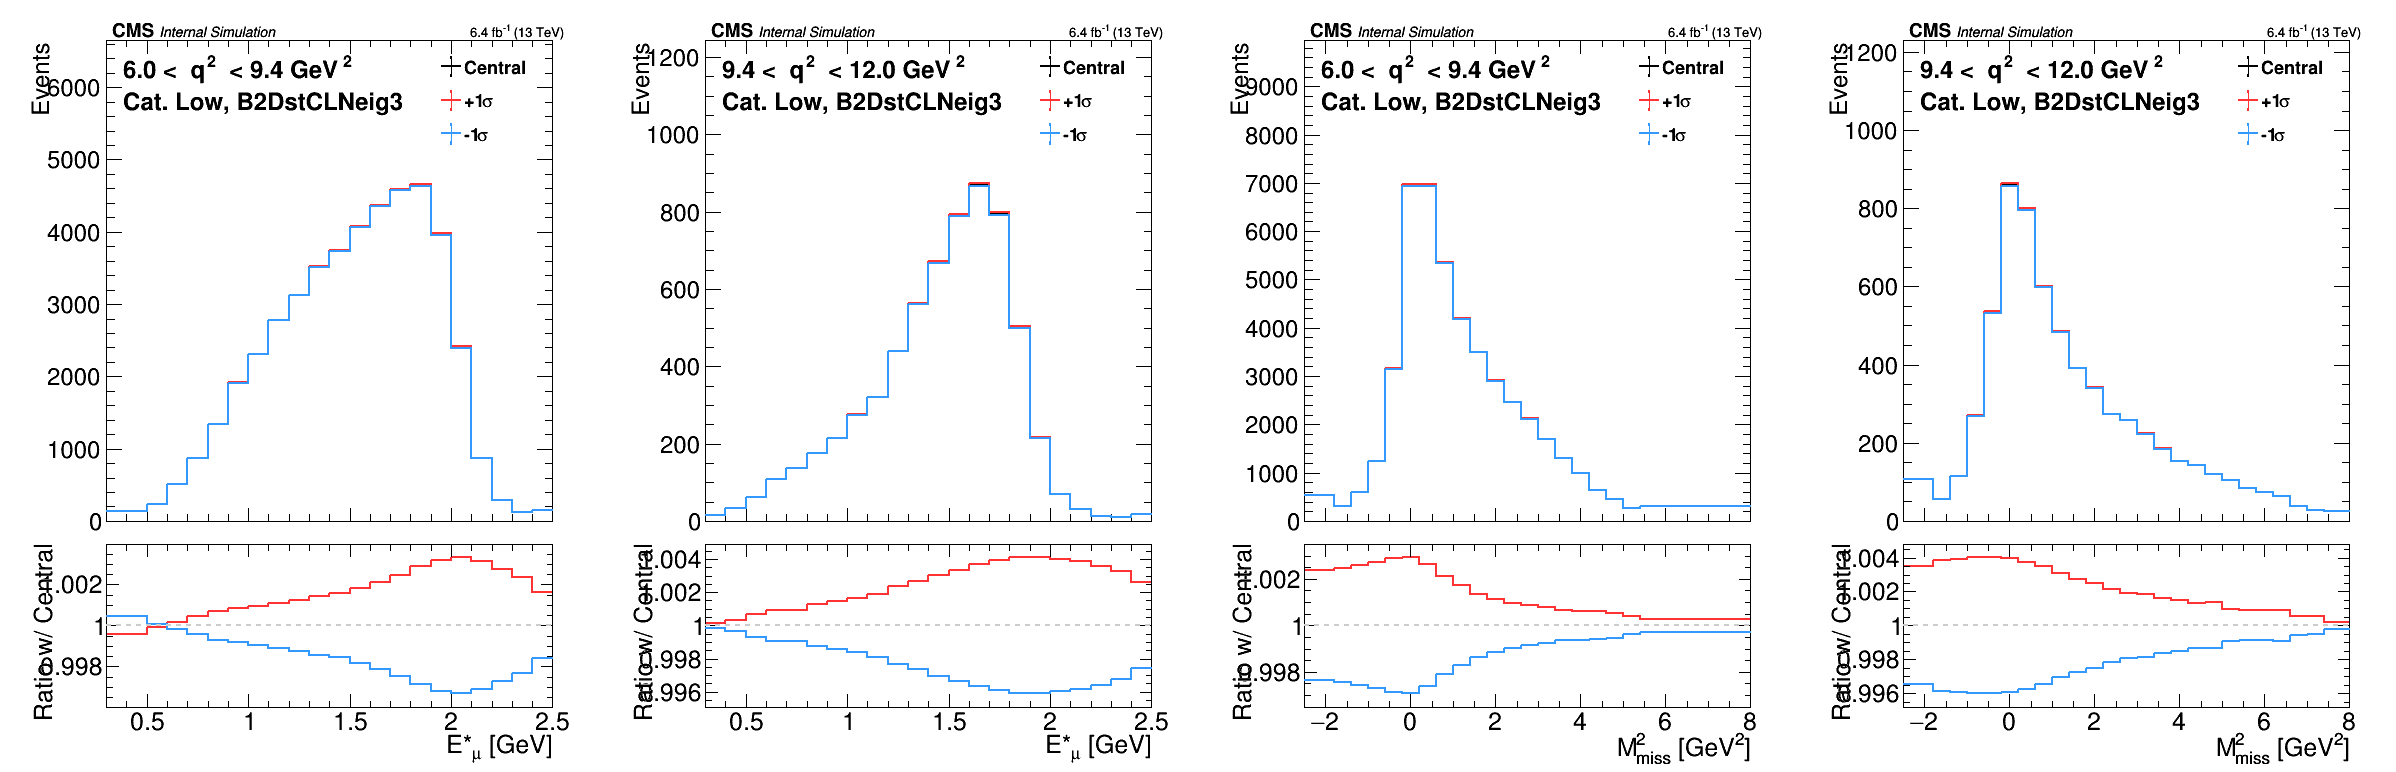

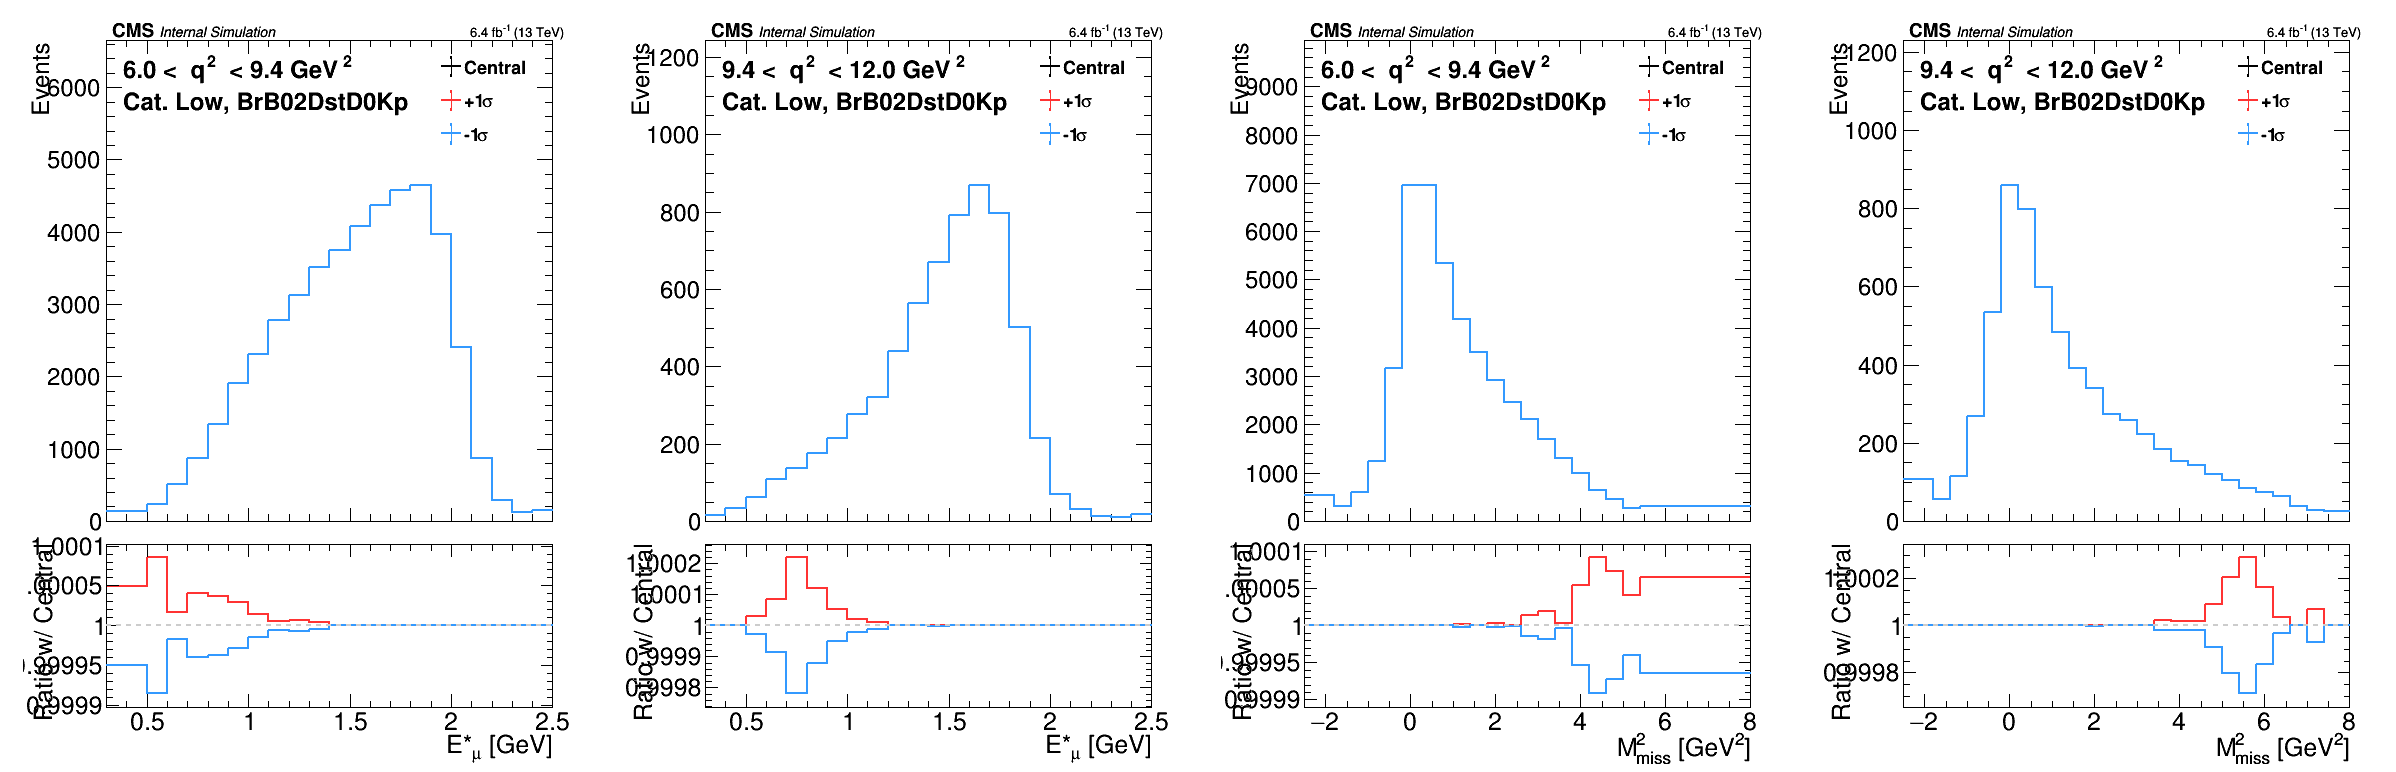

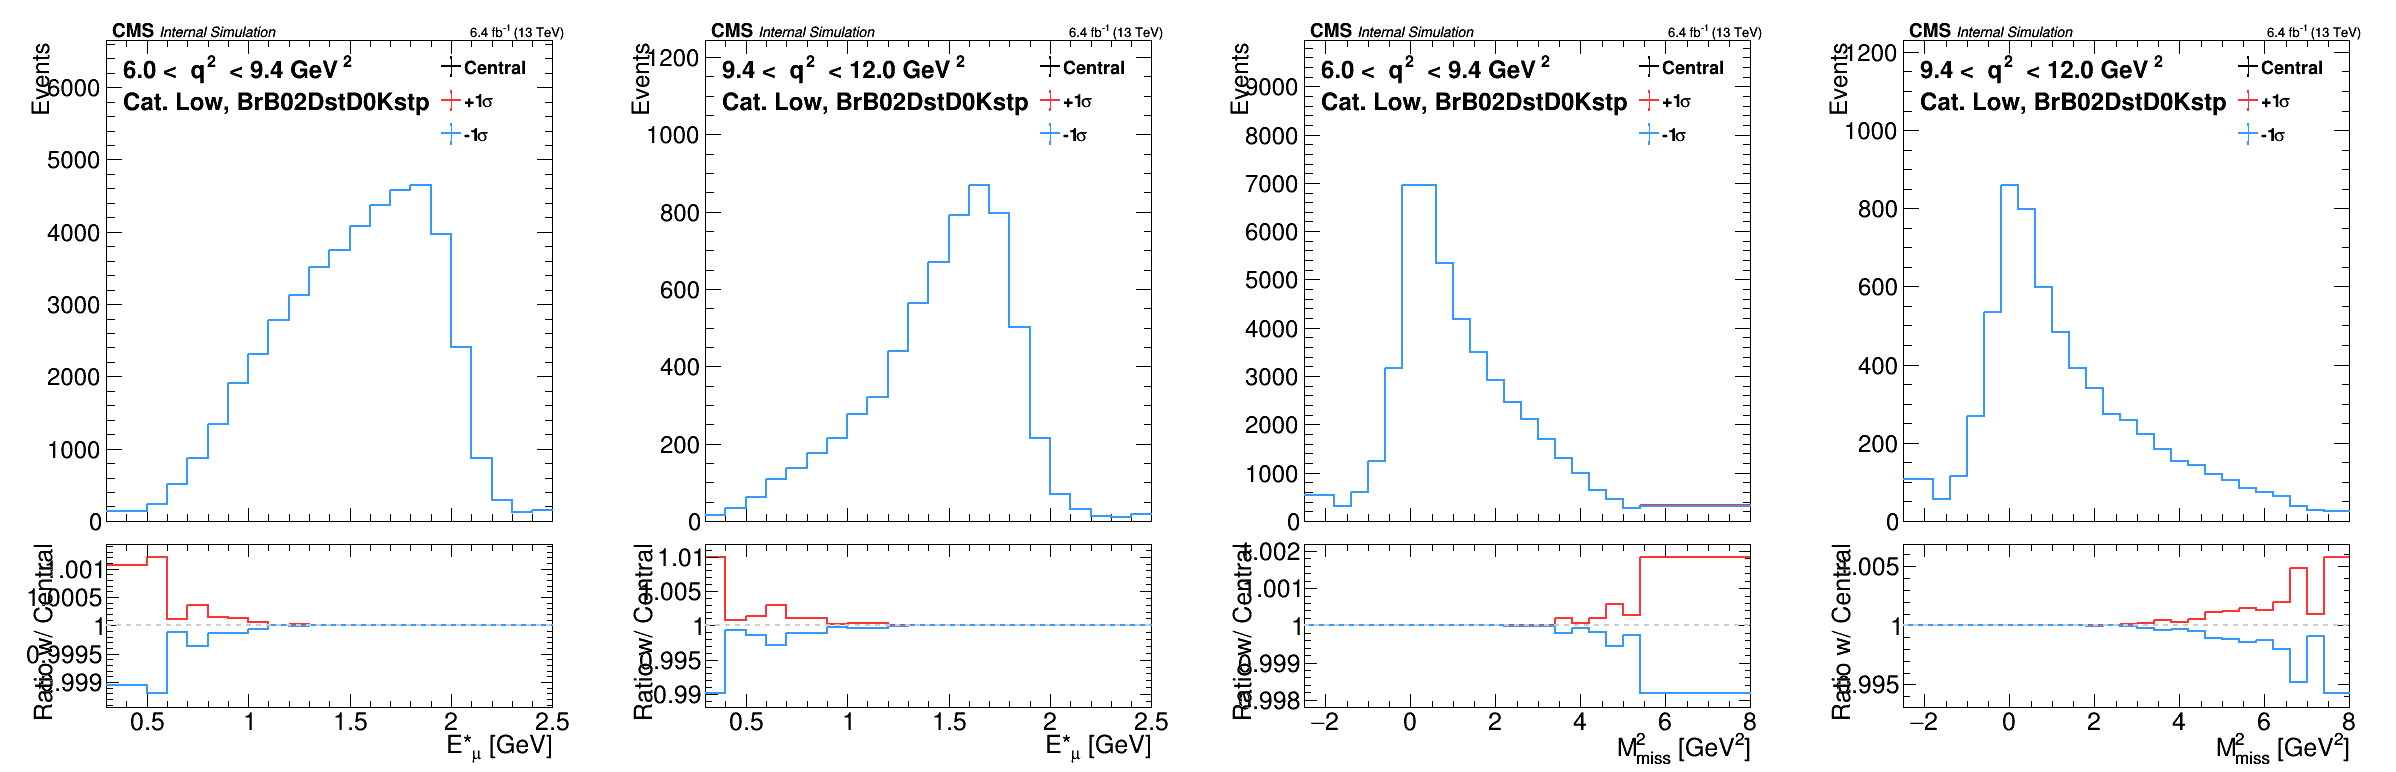

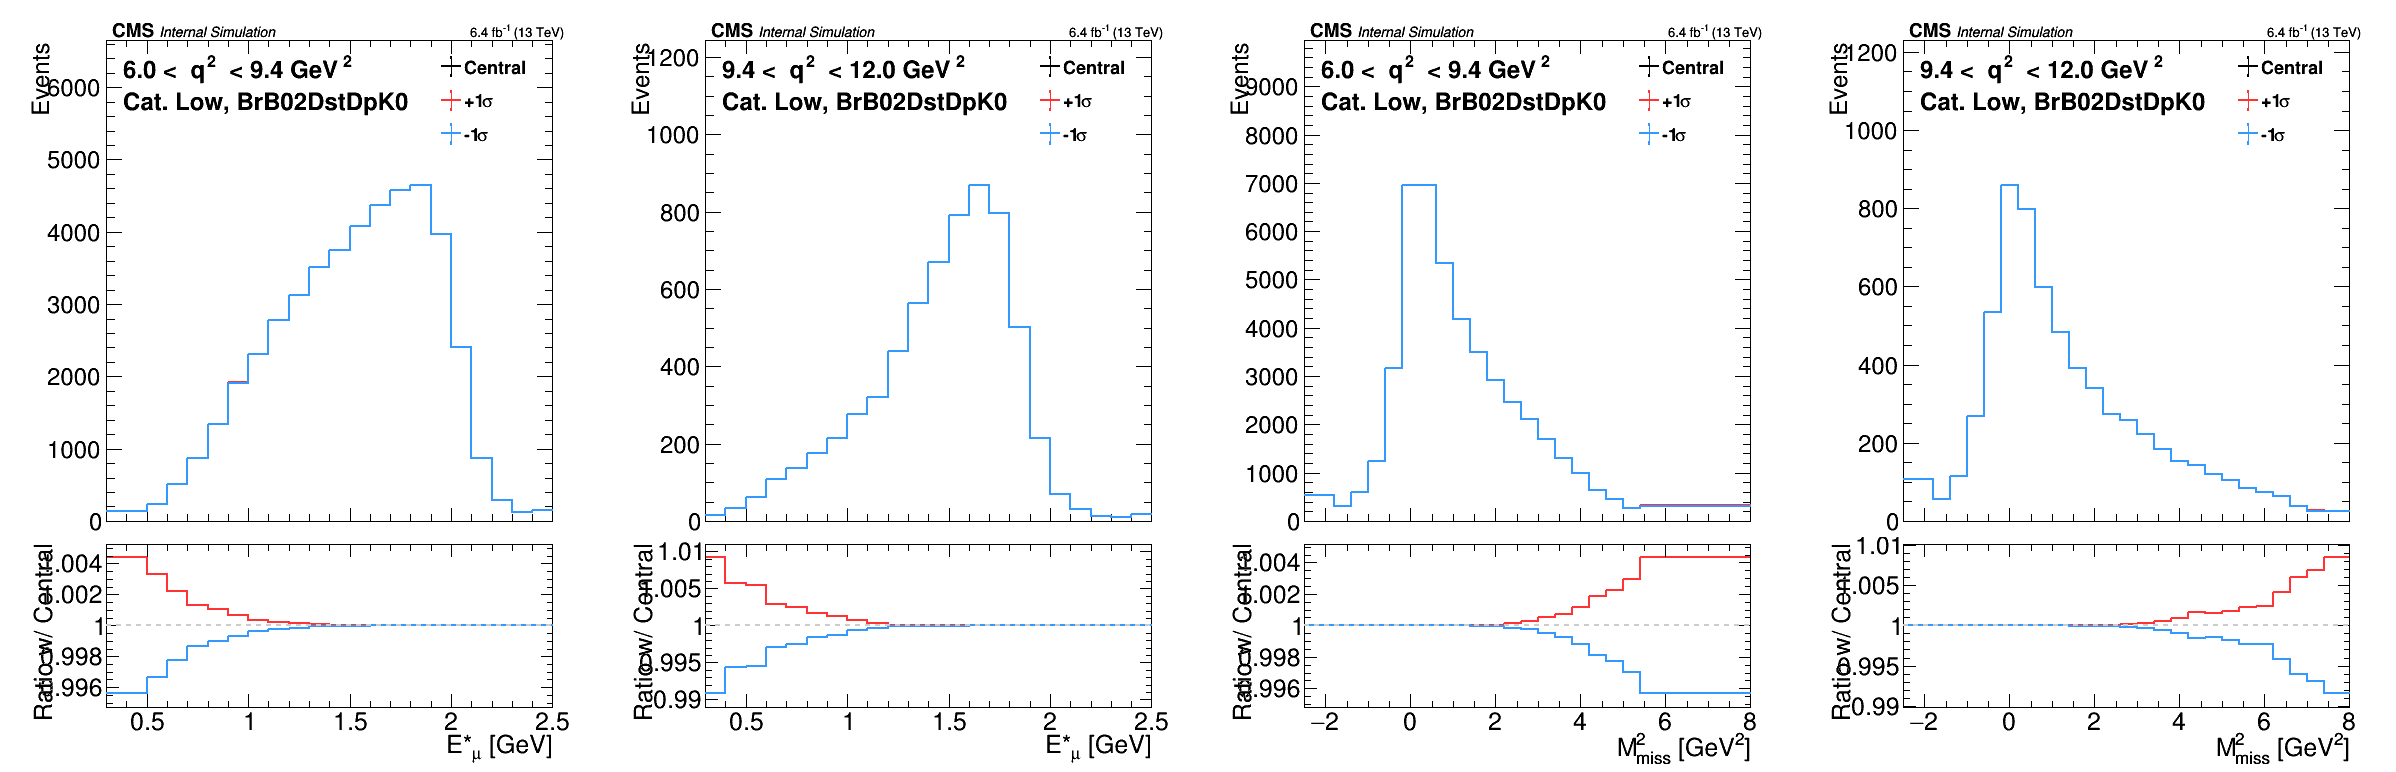

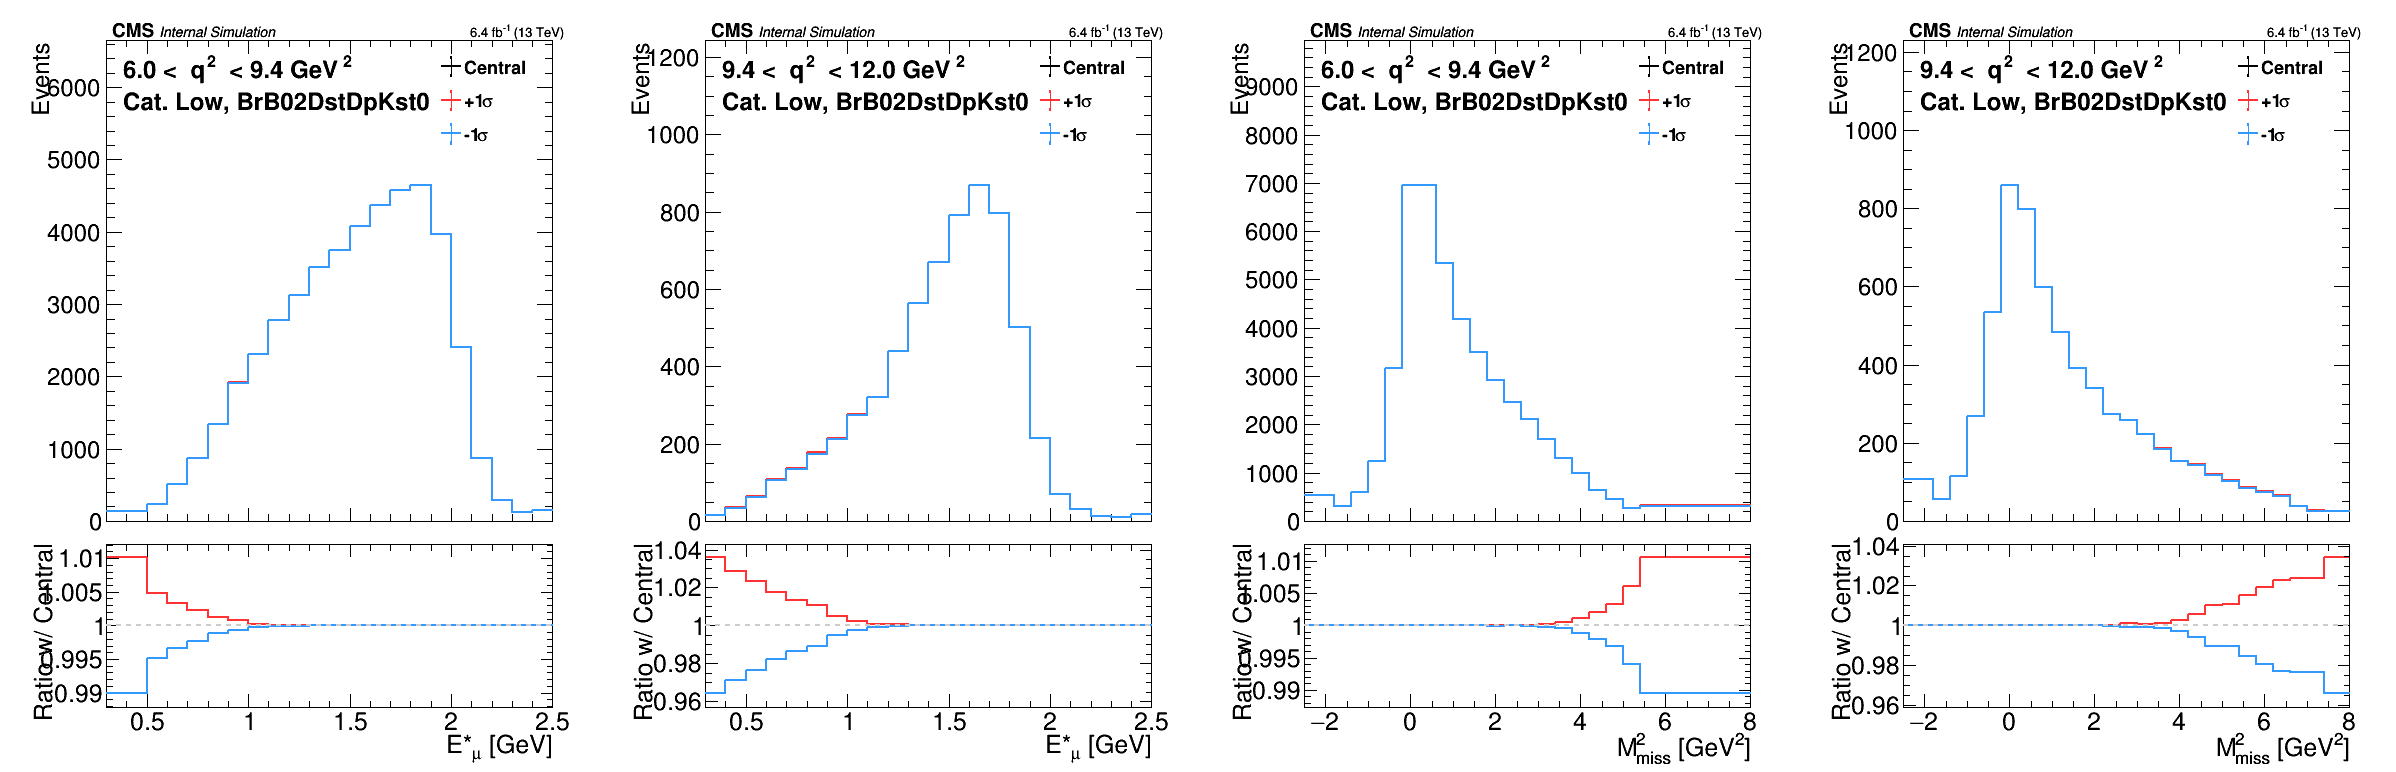

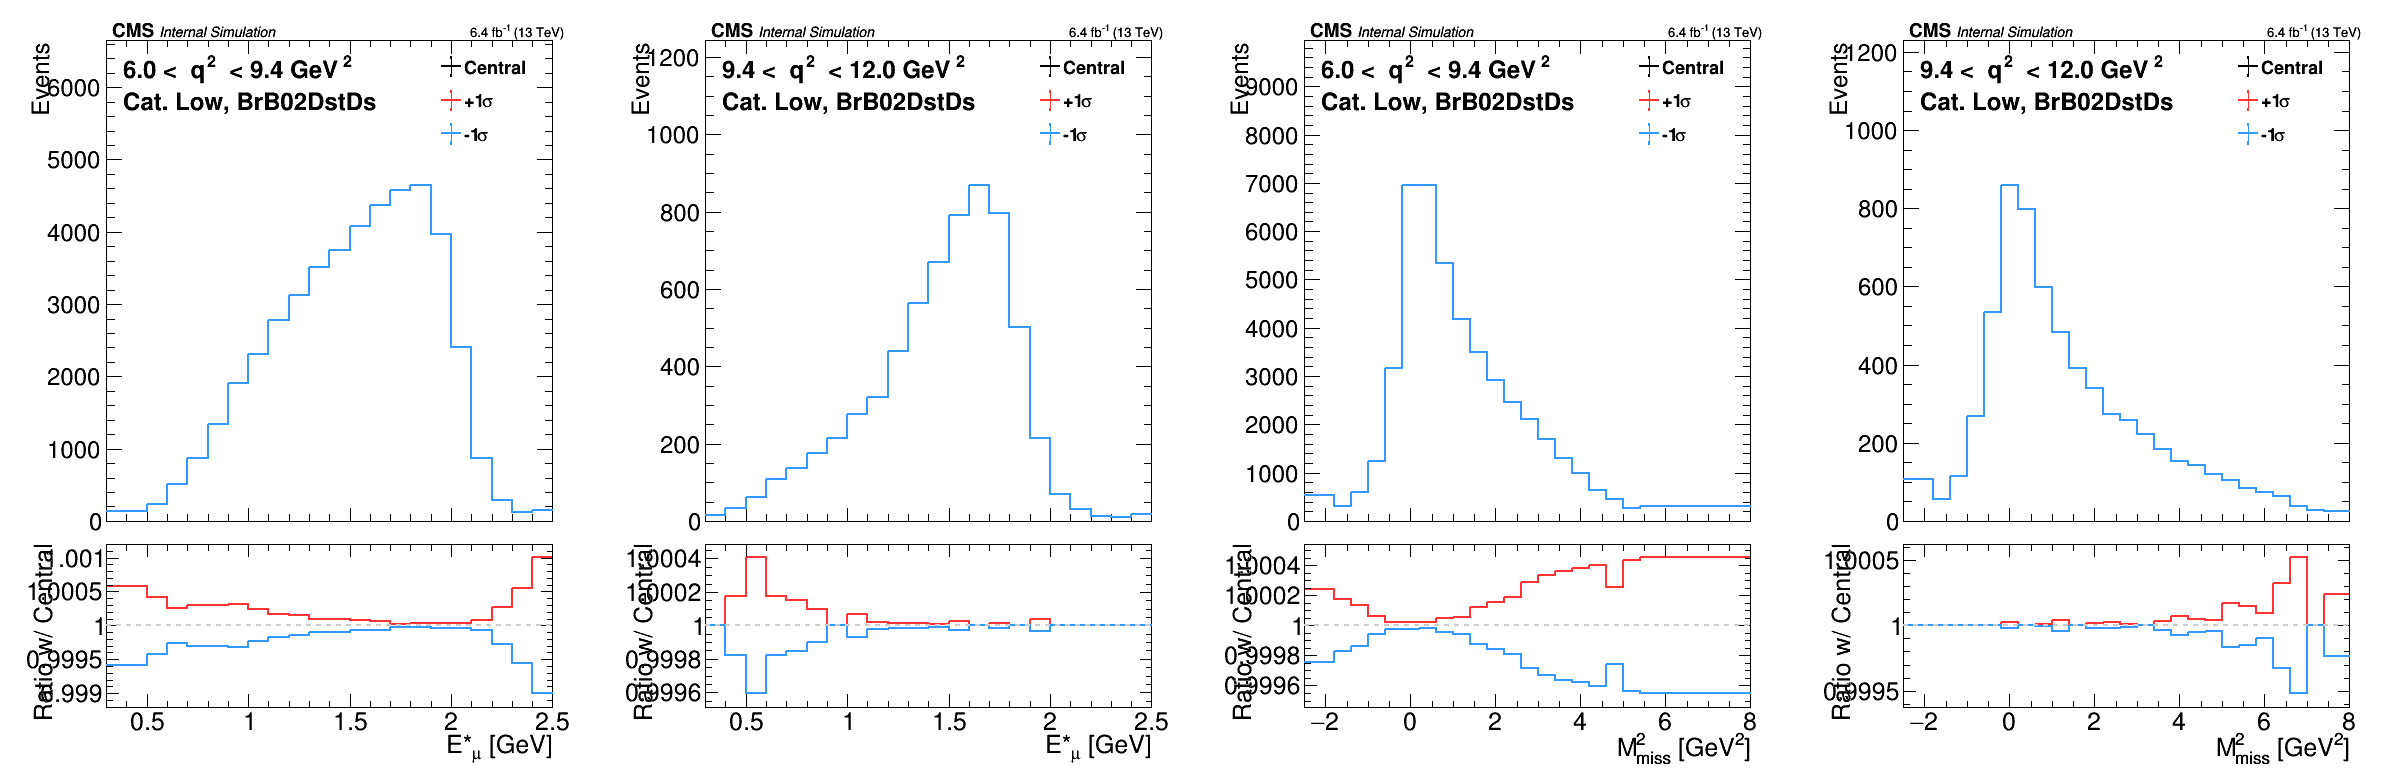

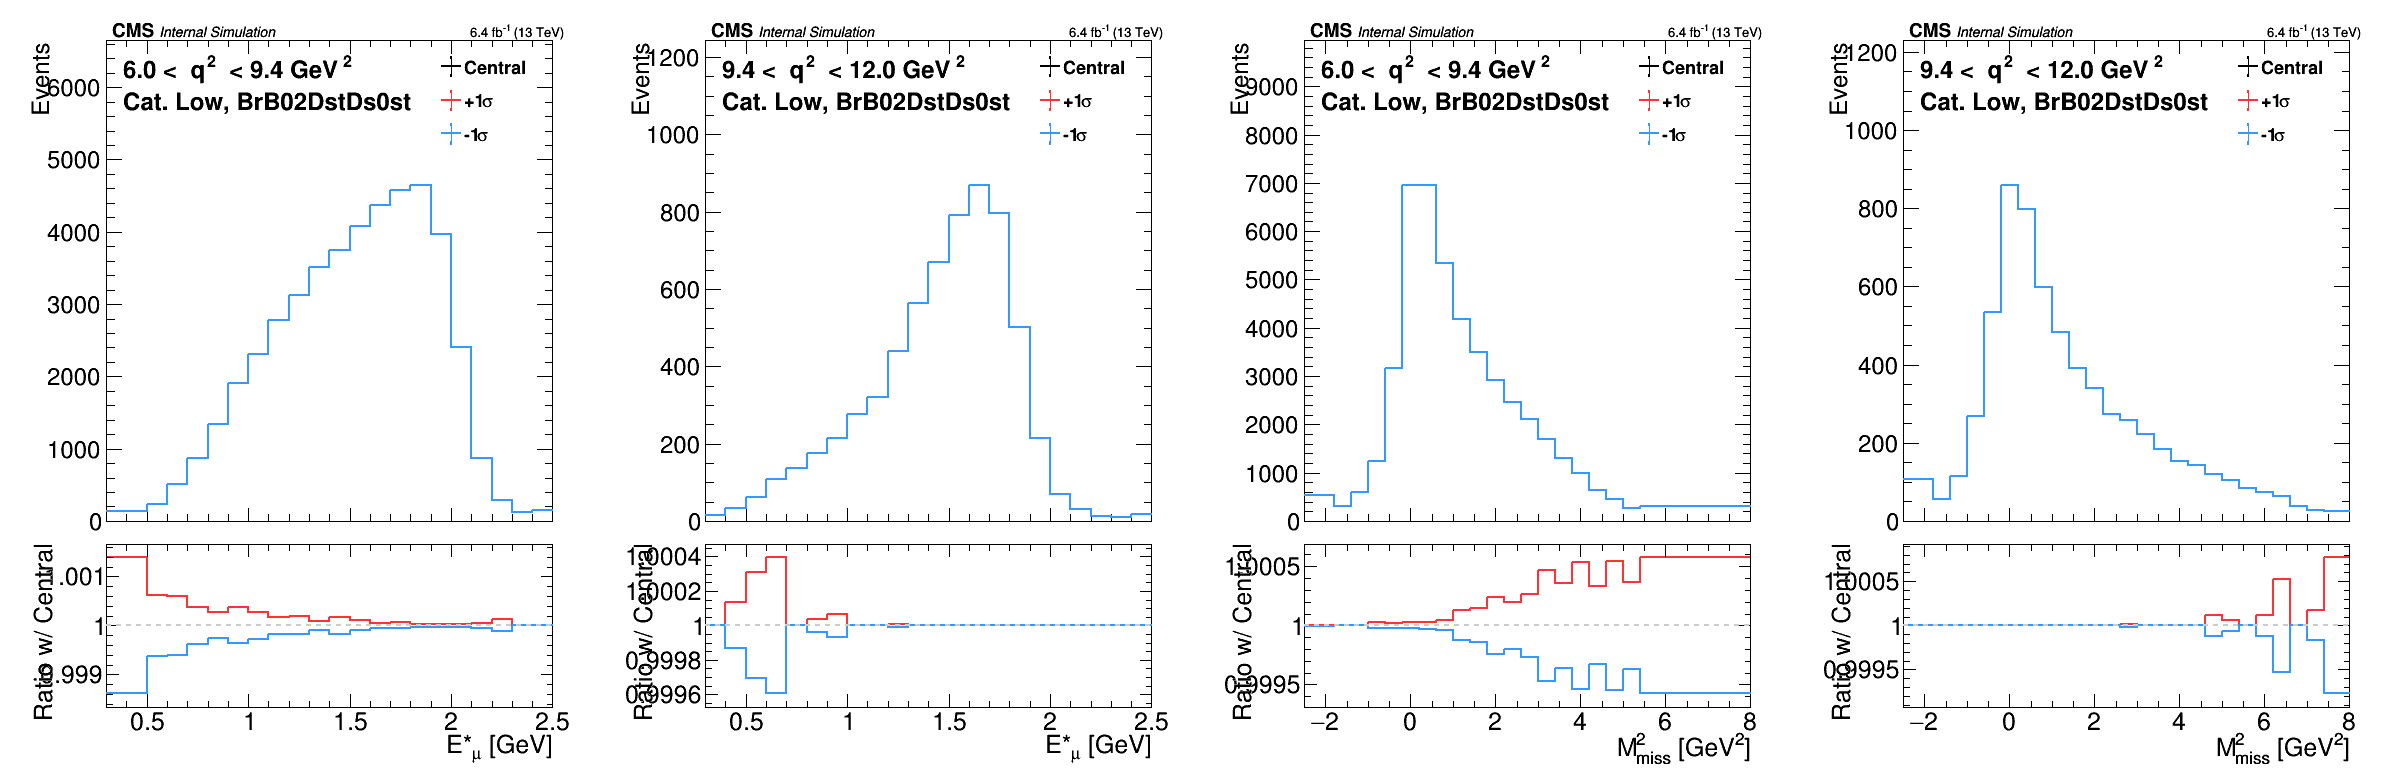

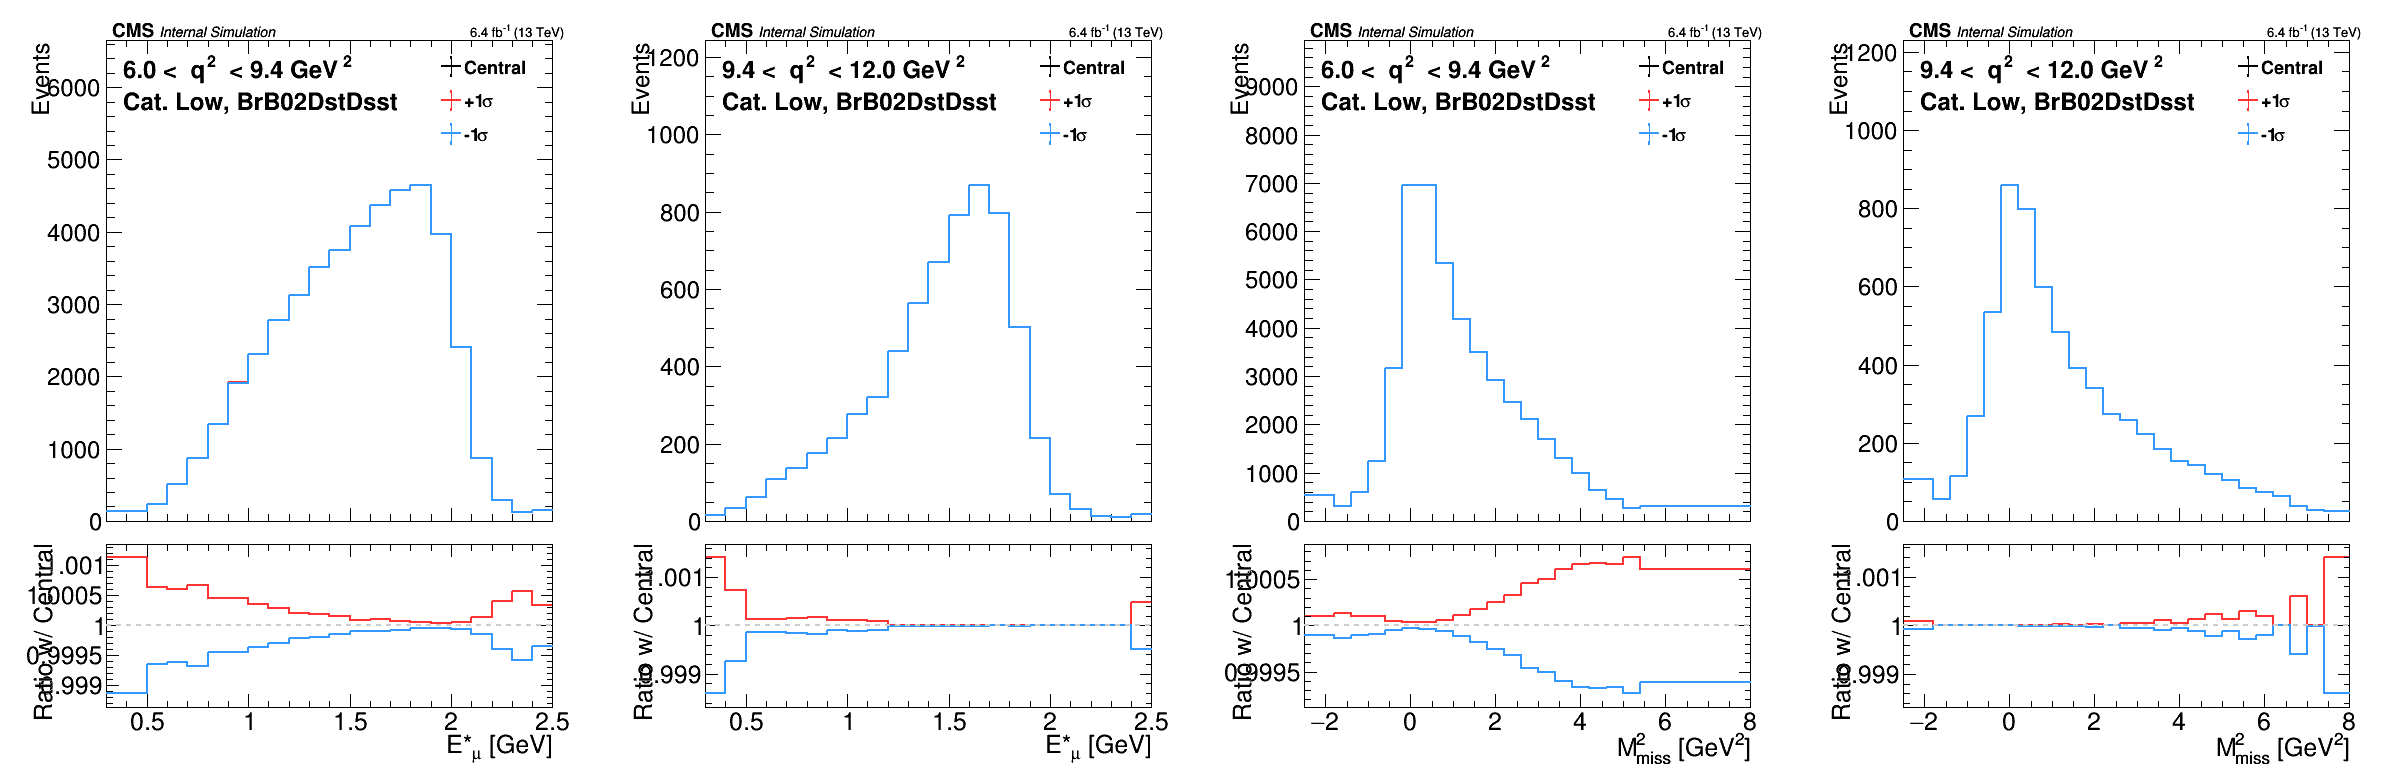

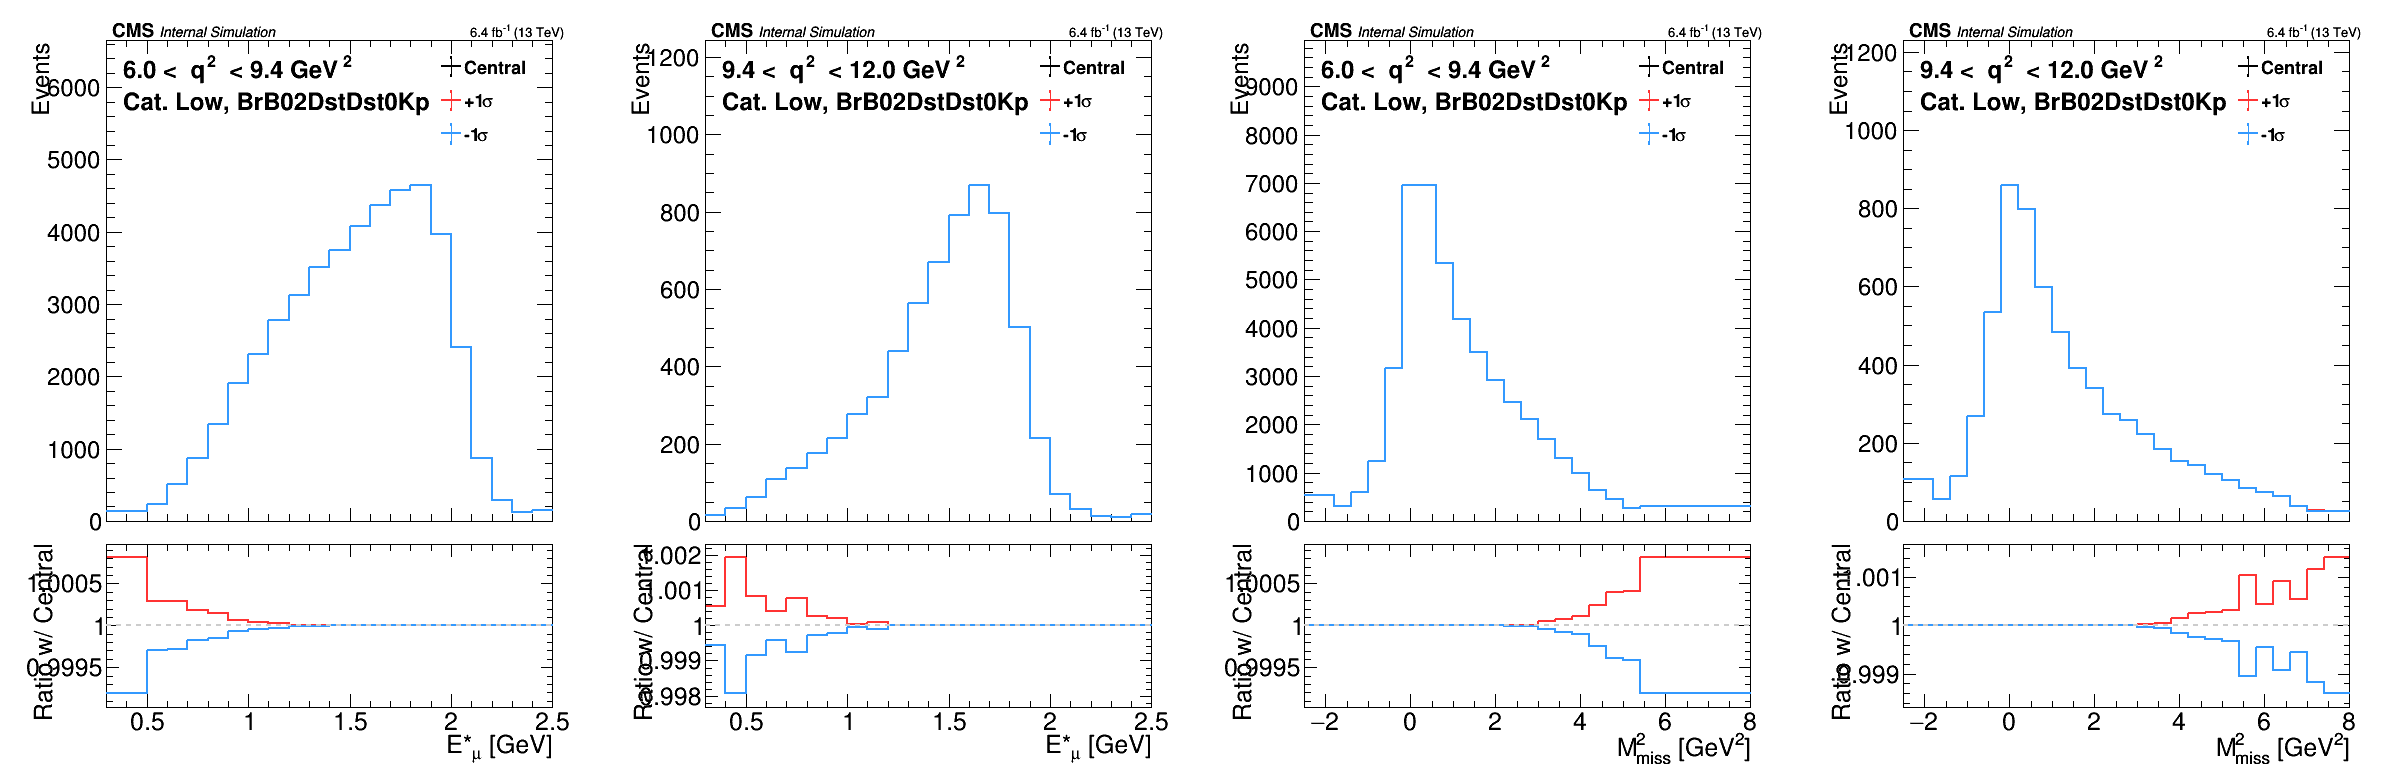

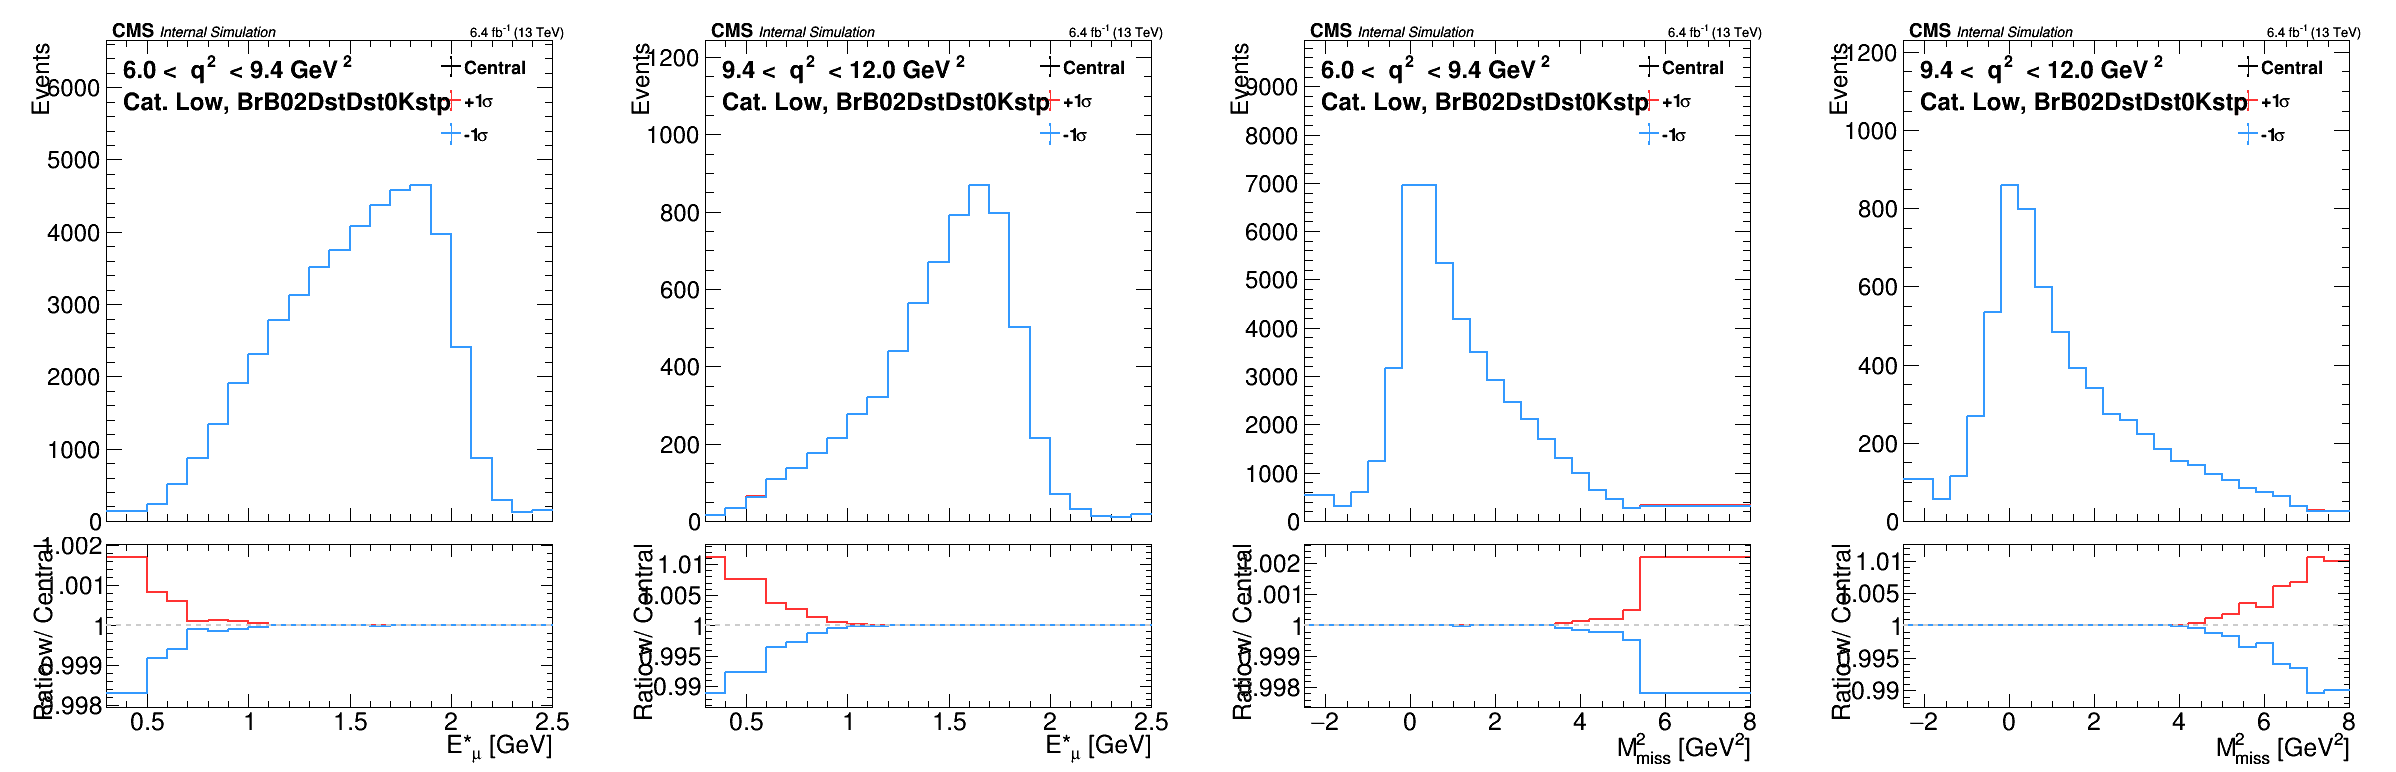

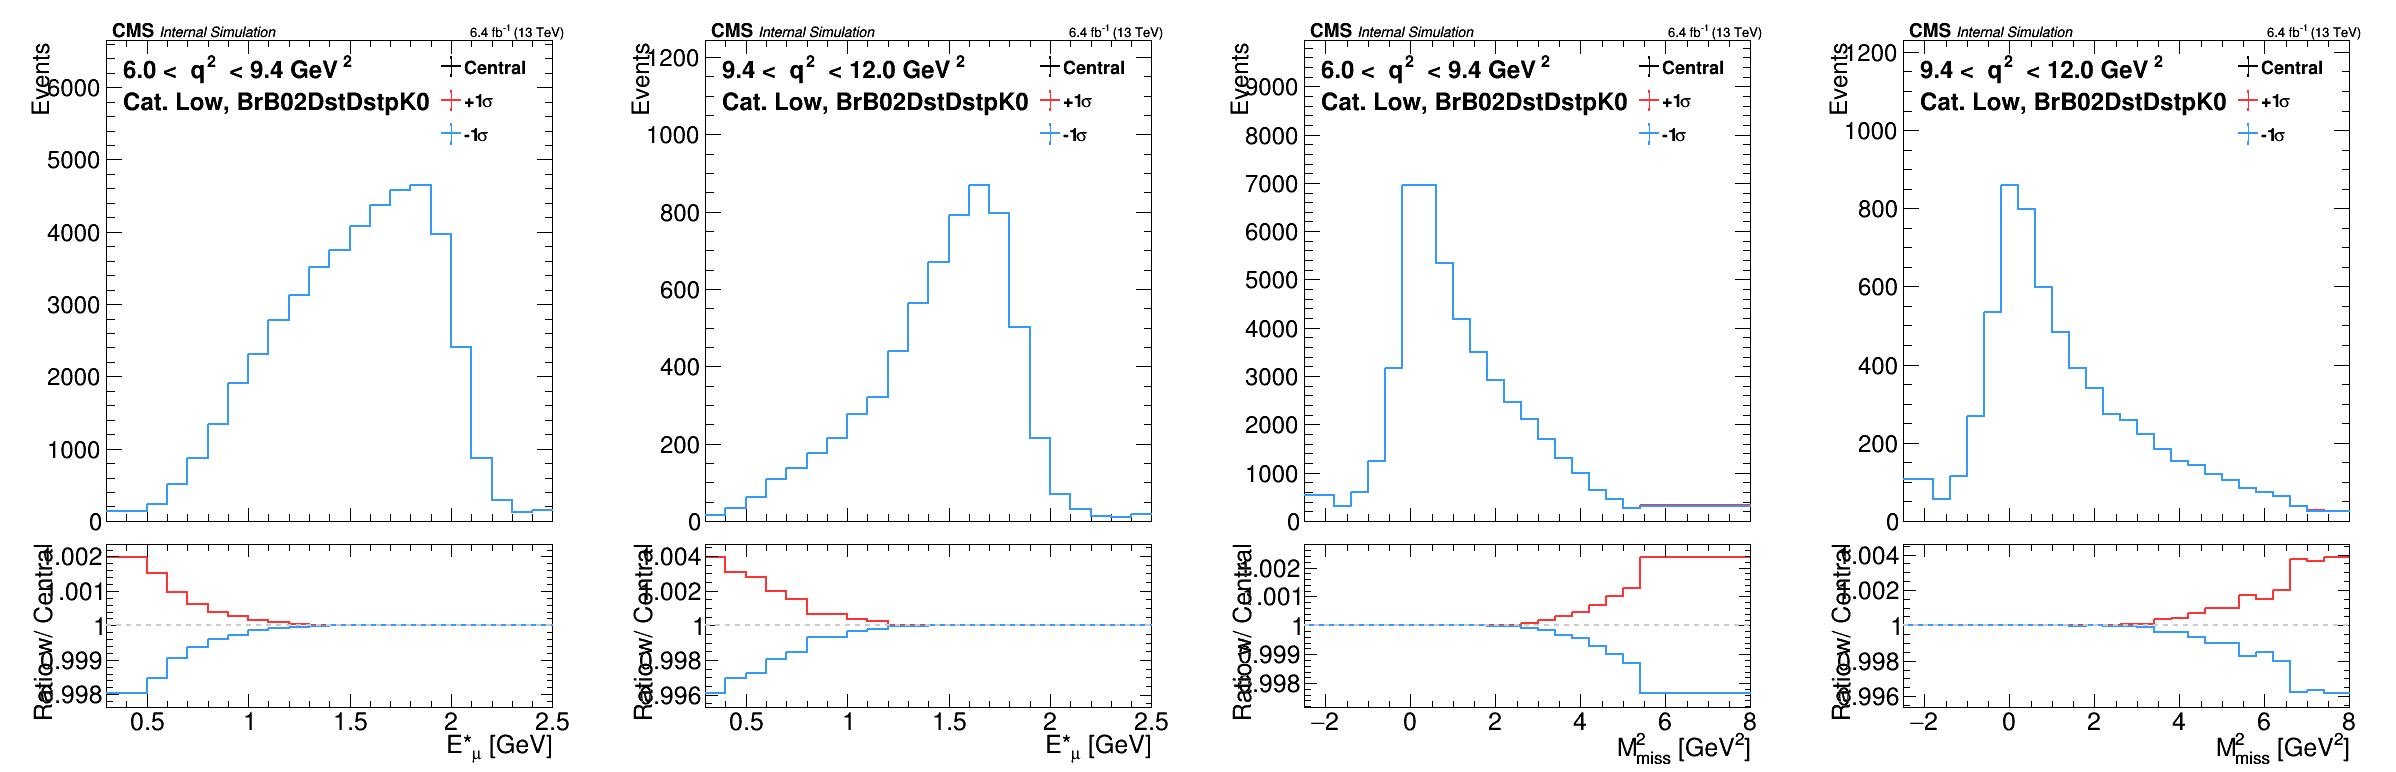

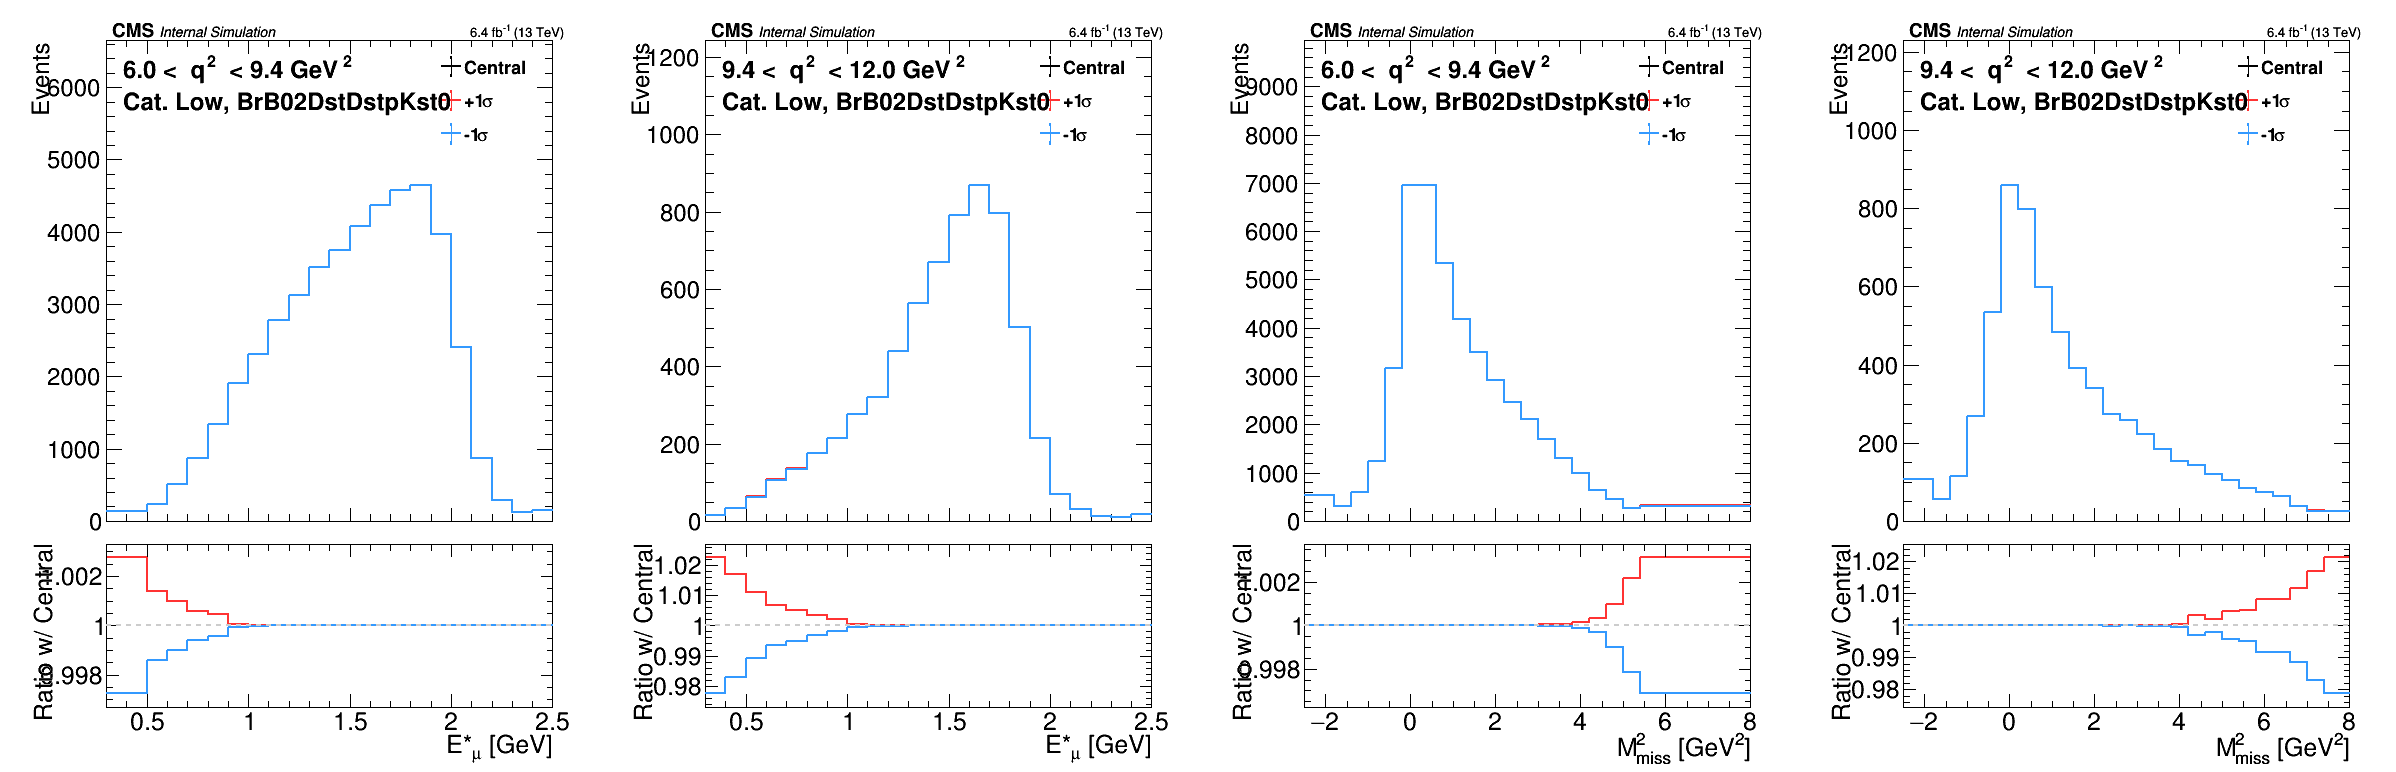

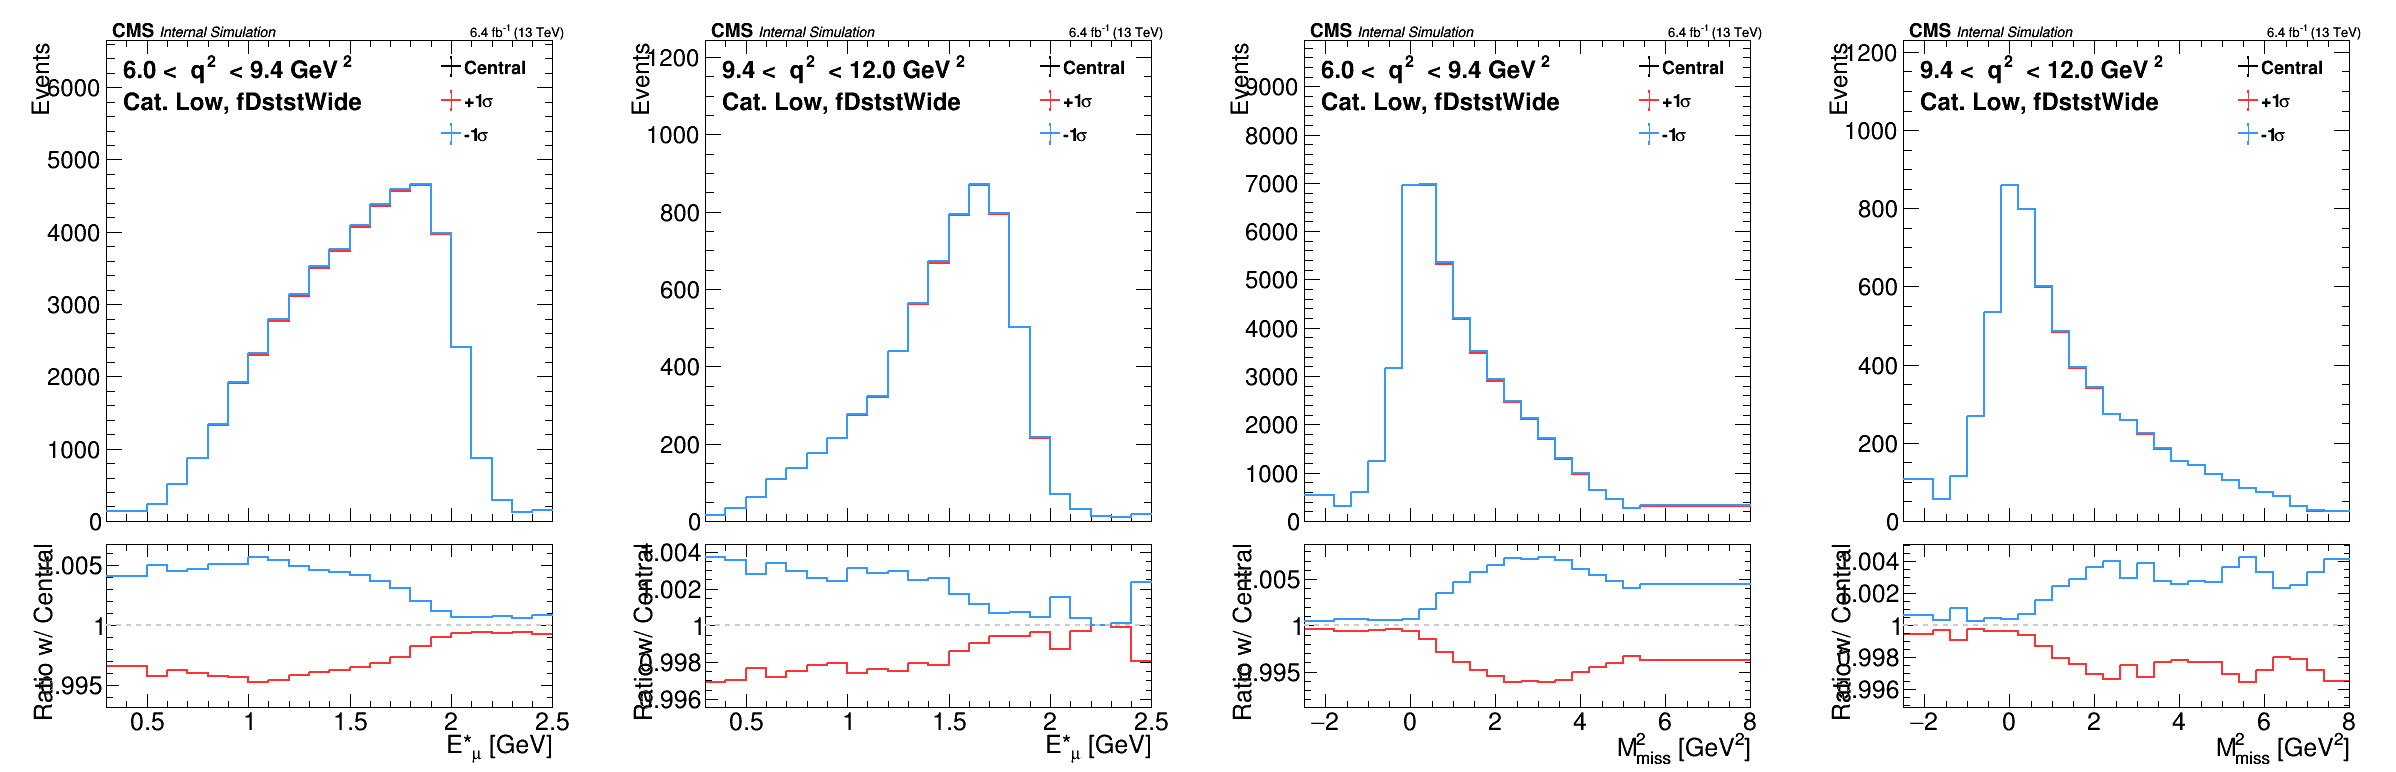

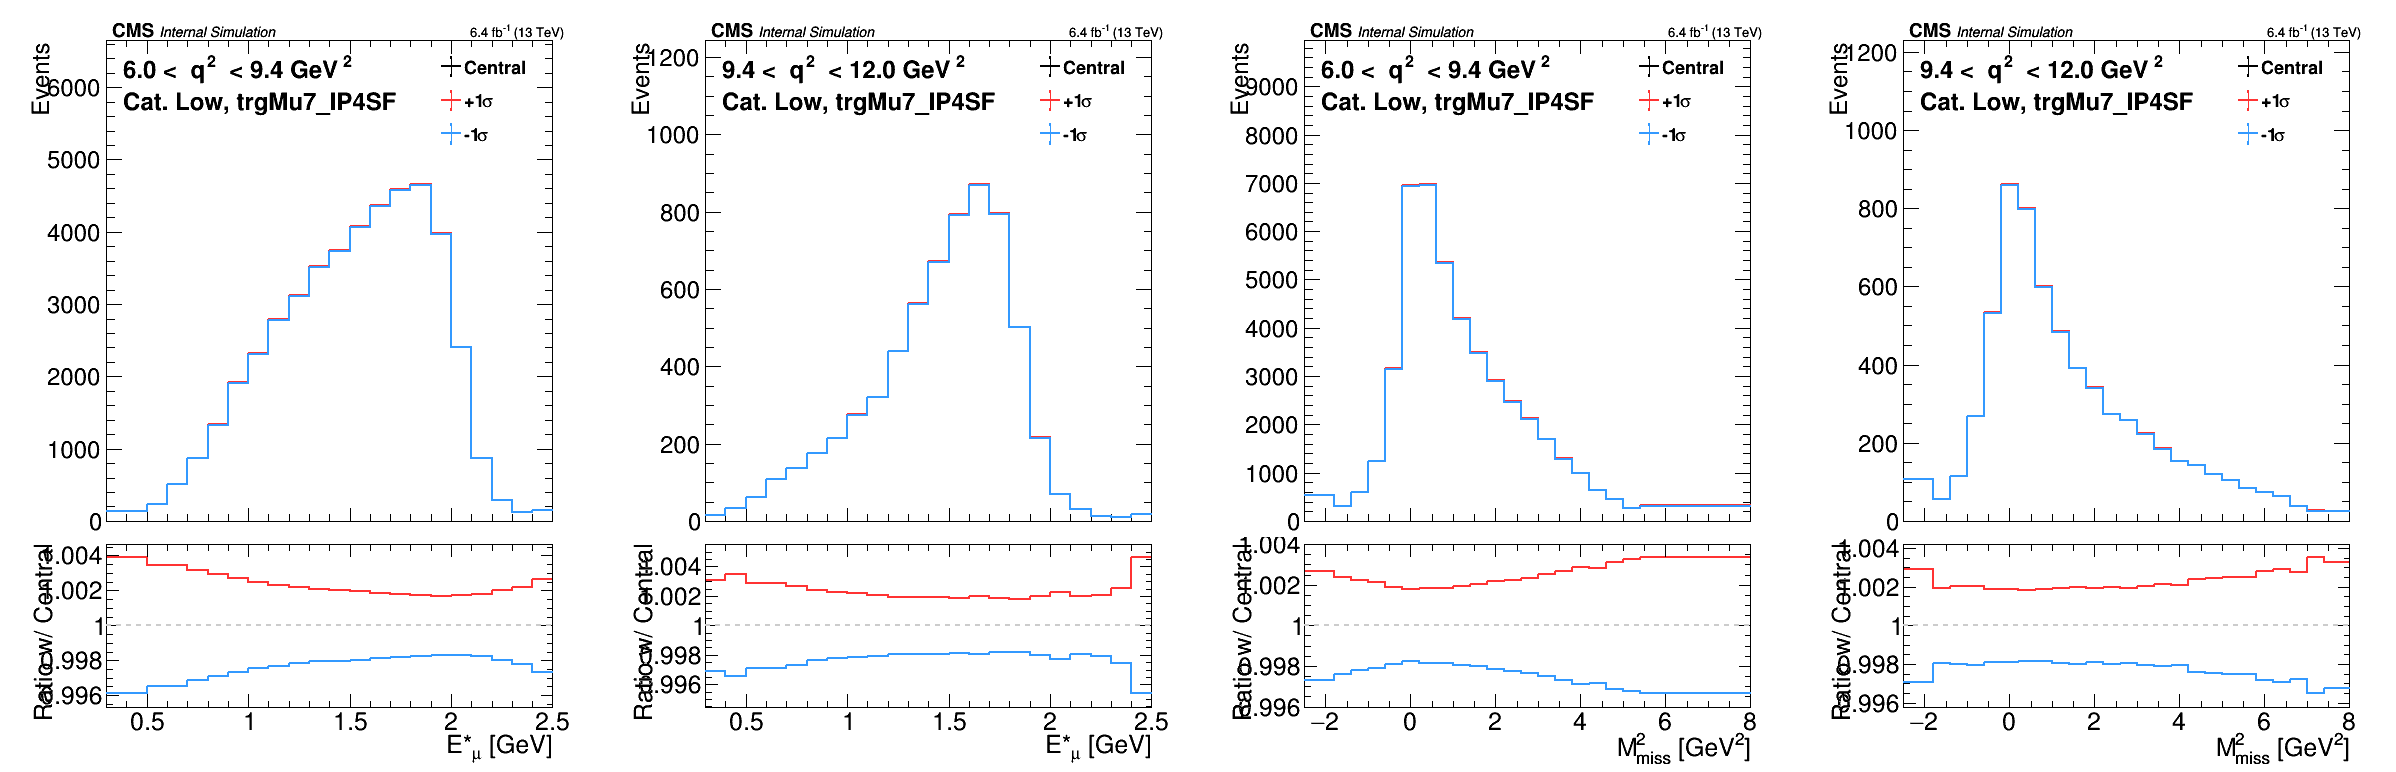

In [11]:
dndM = []
for var in variationsList:
    hUp = getVarHistos(var+'Up')
    hDown = getVarHistos(var+'Down')

    c_out = rt.TCanvas('cOut_'+var, 'cOut_'+var, len((fileH.keys()))*600, 800)
    c_out.Divide(len((fileH.keys())))
    dnd = []

    for ik, kk in enumerate(np.sort(fileH.keys())):
        pad = c_out.cd(ik+1)

        hUp[kk].SetLineColor(rt.kRed-4)
        hUp[kk].SetTitle('+1#sigma')
        hDown[kk].SetLineColor(rt.kAzure+1)
        hDown[kk].SetTitle('-1#sigma')
        hl = [hCentral[kk], hUp[kk], hDown[kk]]
        for h in hl:
            h.Sumw2(0)
            h.SetMarkerStyle(2)
            h.SetMarkerSize(2)
            h.SetMarkerColor(h.GetLineColor())
        c = make_ratio_plot(hl, 
                            draw_opt='',
                            in_pad = pad,
                            leg_pos=[0.75,0.73,0.95,0.92],
                            marginTop=0.062,
                            label = var+kk,
                            ratio_bounds='auto')

        txt = rt.TLatex()
        txt.SetTextSize(0.05)
        txt.SetTextAlign(13)
        idx = int(kk[-1])
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2binning[idx], q2binning[idx+1])
        cat_txt = 'Cat. ' + category.capitalize() + ', ' + var
        c.pad1.cd()
        txt.DrawLatexNDC(0.18, 0.91, '#splitline{'+q2_txt+'}{'+cat_txt+'}')
        CMS_lumi.CMS_lumi(c, -1, 0)

        c.Draw()
        dnd.append(c)

    c_out.Draw()
    c_out.SaveAs(outdir+'/'+var+'.png')
    dndM.append([c_out, dnd])